In [1]:
import sys
import torch
import numpy as np
import scipy.signal
from torchvision.io import read_image
import torch.nn as nn
import torchvision 
from torchvision import transforms 
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
#一维卷积
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)    #使用 NumPy 的 zeros 函数创建了一个长度为 p 的一维数组，数组中的所有元素都是 0
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])   #使用 NumPy 的 concatenate 函数将三个数组拼接在一起
    res = []
    for i in range(0, (int((len(x_padded) - len(w_rot))/s) + 1) * s, s):
        res.append(np.sum(x_padded[i:i + w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

In [3]:
print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


In [4]:
#二维卷积
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]#取反
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, (int((X_padded.shape[0] -
                            W_rot.shape[0]) / s[0]) + 1) * s[0], s[0]):
        res.append([])
        for j in range(0, (int((X_padded.shape[1] -
                                W_rot.shape[1]) / s[1]) + 1) * s[1], s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0],
                    j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

In [5]:
print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


In [6]:
img = read_image('example-image.png') 
 
print('Image shape:', img.shape)
print('Number of channels:', img.shape[0])#通道数
print('Image data type:', img.dtype)
print(img[:, 100:102, 100:102])

Image shape: torch.Size([3, 252, 221])
Number of channels: 3
Image data type: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


In [7]:
###14.2.2使用L2范数和dropout对神经网络正则化
#此处将指定层的L2惩罚项添加到损失函数中
loss_func = nn.BCELoss()    #定义了一个二分类交叉熵损失函数BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))  #该损失值基于预测值0.9和真实标签1.0
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)   
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])    #对于卷积层，计算了所有参数的平方和，然后乘以l2_lambda得到L2正则化项。
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty



In [8]:
# ## Loss Functions for Classification分类任务的损失函数
#  * **`nn.BCELoss()`** 二分类
#    * `from_logits=False` 
#    * `from_logits=True`
#  * **`nn.CrossEntropyLoss()`**多分类
#    * `from_logits=False`
#    * `from_logits=True`
##使用PyTorch计算二分类交叉熵损失（BCE）和多分类交叉熵损失（CCE，也称为多分类交叉熵损失）
####### Binary Cross-entropy
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)#将logits通过sigmoid函数转换为概率。
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()#使用BCELoss计算概率和目标标签之间的损失。这里的目标标签应该是0到1之间的浮点数，表示真实类别为1的概率（在二分类问题中）。
bce_logits_loss_fn = nn.BCEWithLogitsLoss()#使用BCEWithLogitsLoss，它内部会先对logits应用sigmoid函数，然后再计算BCE。这样做的好处是数值上更稳定，并且计算效率更高。

print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}') #输入值是使用logits计算的类别概率
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')  #输入值是logits值

 
####### Categorical Cross-entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss_fn = nn.NLLLoss()  
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')  #根据logits值计算对数概率
print(f'CCE (w Probas): {cce_loss_fn(torch.log(probas), target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711
CCE (w Logits): 0.5996
CCE (w Probas): 0.5996


In [9]:
#14.3使用Pytorch实现深度卷积神经网络
#14.3.1
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9912422/9912422 [08:38<00:00, 19108.28it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28881/28881 [00:01<00:00, 17428.62it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1648877/1648877 [01:09<00:00, 23703.73it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4542/4542 [00:00<00:00, 3020058.46it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [10]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [11]:
#14.3.3使用torch.nn模块实现卷积神经网络
model = nn.Sequential() #创建一个空的顺序容器，使用nn.Sequential()类来组合各种网络层
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())   #ReLU（Rectified Linear Unit）激活函数，用于增加网络的非线性。     
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  #添加第一个池化层 
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))  #x 是一个使用 PyTorch 创建的张量，其形状为 (4, 1, 28, 28)。这个张量可以被解释为一个批次（batch）包含 4 张灰度图像，每张图像的尺寸为 28x28 像素，且只有一个颜色通道（因为是灰度图）。
model(x).shape

torch.Size([4, 64, 7, 7])

In [12]:
model.add_module('flatten', nn.Flatten())       #向模型中添加了一个扁平化（flatten）层。这个层的作用是将输入的多维张量（通常是多维的特征图）转换为一维的张量，以便可以输入到全连接层（fully connected layers，也称为线性层）中。

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [13]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU())    # ReLU 激活函数层（relu3）
model.add_module('dropout', nn.Dropout(p=0.5)) #Dropout层在训练期间会随机丢弃一些神经元，但输出形状保持不变；在评估/推理期间，所有神经元都会被保留，但输出会按丢弃比例进行缩放

model.add_module('fc2', nn.Linear(1024, 10))    #向模型中添加了两个全连接层（fc1 和 fc2）

In [14]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

model = model.to(device) 

In [15]:
loss_fn = nn.CrossEntropyLoss()#PyTorch的nn.CrossEntropyLoss函数内部会自动处理softmax计算，因此模型输出层不需要再额外加softmax层。
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
#在训练时添加model.train()，在测试时添加model.eval()，这样可以自动设置dropout层的模式并自动缩放网络的输出
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    """
    loss_hist_train 和 accuracy_hist_train 用于存储每个训练轮次的损失值和准确率。
    loss_hist_valid 和 accuracy_hist_valid 用于存储每个验证轮次的损失值和准确率。
    """
    for epoch in range(num_epochs):
        ##########训练
        model.train()#对于每个训练轮次（epoch），首先将模型设置为训练模式（model.train()）
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)#通过模型进行预测（pred）。
            loss = loss_fn(pred, y_batch)#计算损失（loss）。
            loss.backward()#使用反向传播计算梯度（loss.backward()）。
            optimizer.step()#更新模型参数（optimizer.step()）。
            optimizer.zero_grad()#清零梯度（optimizer.zero_grad()），为下一个批次做准备。
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()#累加该批次的损失和正确预测的数量，以便后续计算平均损失和准确率。
        #对于每个轮次，将累加的损失和正确预测的数量除以数据集的总大小，得到平均损失和准确率。
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        
        ########验证
        model.eval()#在每个训练轮次结束后，将模型设置为评估模式（model.eval()），并禁用梯度计算（with torch.no_grad()）。
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:#遍历验证数据加载器（valid_dl），对于每个批次的数据，执行与训练循环类似的步骤，但不进行参数更新。
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [17]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9497 val_accuracy: 0.9824
Epoch 2 accuracy: 0.9841 val_accuracy: 0.9868
Epoch 3 accuracy: 0.9902 val_accuracy: 0.9828
Epoch 4 accuracy: 0.9920 val_accuracy: 0.9892
Epoch 5 accuracy: 0.9926 val_accuracy: 0.9877
Epoch 6 accuracy: 0.9947 val_accuracy: 0.9896
Epoch 7 accuracy: 0.9953 val_accuracy: 0.9895
Epoch 8 accuracy: 0.9964 val_accuracy: 0.9898
Epoch 9 accuracy: 0.9963 val_accuracy: 0.9901
Epoch 10 accuracy: 0.9966 val_accuracy: 0.9902
Epoch 11 accuracy: 0.9965 val_accuracy: 0.9879
Epoch 12 accuracy: 0.9978 val_accuracy: 0.9902
Epoch 13 accuracy: 0.9970 val_accuracy: 0.9885
Epoch 14 accuracy: 0.9973 val_accuracy: 0.9910
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9904
Epoch 16 accuracy: 0.9977 val_accuracy: 0.9894
Epoch 17 accuracy: 0.9980 val_accuracy: 0.9912
Epoch 18 accuracy: 0.9980 val_accuracy: 0.9915
Epoch 19 accuracy: 0.9980 val_accuracy: 0.9893
Epoch 20 accuracy: 0.9983 val_accuracy: 0.9899


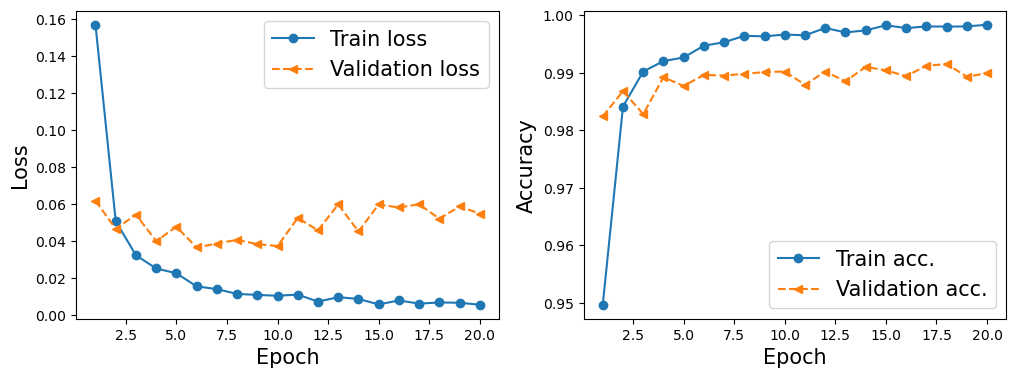

In [18]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [19]:
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9913


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Study\\GitWorkplace\\pytorchStudy\\PytorchStudy\\mlBook\\ch14\\figures\\14_14.png'

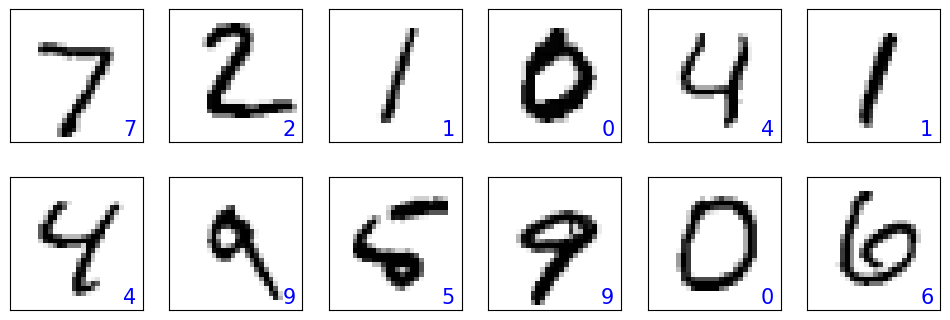

In [20]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
plt.savefig('figures/14_14.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Study\\GitWorkplace\\pytorchStudy\\PytorchStudy\\mlBook\\ch14\\figures\\14_14.png'

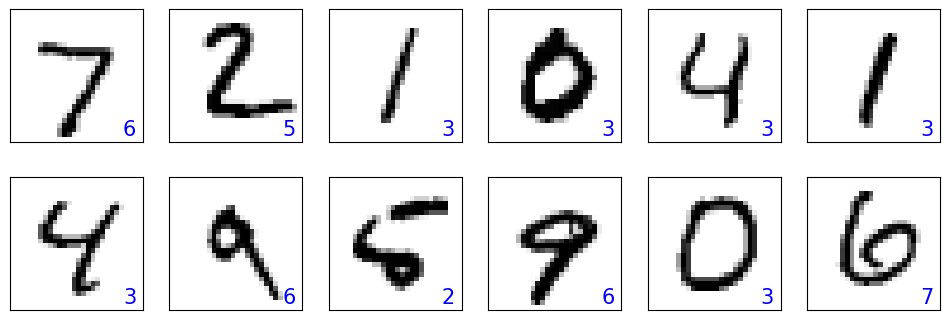

In [21]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmin(pred) 
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
plt.savefig('figures/14_14.png')
plt.show()